# **📊 IPL Match Phase Analysis Project**

This project analyzes IPL matches by dividing them into three distinct phases: **Powerplay**, **Middle Overs**, and **Death Overs**.  
It explores both **batting** and **bowling** performances across these phases for individual players and teams.


 **📌 Project Objective:**  
- Generate detailed phase-wise performance metrics
- Compare team and player statistics over time
- Visualize run rates, strike rates, economy, and more
- Derive actionable insights for analysts, coaches, and fans

**Key Questions:**  
- How do run rates, wicket rates, and boundary rates vary by phase?  
- Which teams, batsmen, and bowlers excel in each phase?  
- How did 2025 compare to historical trends (2008–2024)?

# **Executive Summary: IPL Match Phase Analysis**



**Death Overs Domination**: Across all seasons (2008–2025), teams consistently score and concede the highest rates in the Death phase (overs 16–20), underscoring its decisive impact on match outcomes.

**CSK’s Signature Finish**: Chennai Super Kings maintain a historic edge in Death overs wicket-taking—peaking in 2013, 2018, and 2021—correlating directly with their title-winning campaigns.

**Powerplay Volatilit**y: Powerplay performance exhibits the greatest year-over-year variability, reflecting the influence of opening partnerships and rule changes (field restrictions, Impact Player) on early scoring.

**Bowling Trends Shift**: The league-wide mean economy rate rose by over 1 run per over in the recent period versus 2008-2024 (8.31 → 9.49 RPO; p < 0.001, d = 0.51), indicating a sustained increase in batting aggression and run rates.

**Player Performance Consistency** : Top batsmen (e.g., TM Head, Abhishek Sharma) and bowlers (e.g., JC Archer, TA Boult) display significant phase-specific specializations, with six-hitting rates highest in Powerplays and wicket-taking rates highest in Death overs.

# Importin Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Loading dataset

In [2]:
data = pd.read_csv("ipl_combined_df.csv",low_memory=False)
data.head(4)

,match_id,season,date,inning,batting_team,bowling_team,over,ball,striker,bowler,...,winner,result,result_margin,target_runs,super_over,method,cleaned_team_batting,cleaned_team_bowling,cleaned_winner,phase
0,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,...,Kolkata Knight Riders,runs,140,223.0,N,NaN,KKR,RCB,KKR,Powerplay
1,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,...,Kolkata Knight Riders,runs,140,223.0,N,NaN,KKR,RCB,KKR,Powerplay
2,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,...,Kolkata Knight Riders,runs,140,223.0,N,NaN,KKR,RCB,KKR,Powerplay
3,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,...,Kolkata Knight Riders,runs,140,223.0,N,NaN,KKR,RCB,KKR,Powerplay


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278103 entries, 0 to 278102
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   match_id              278103 non-null  int64  
 1   season                278103 non-null  int64  
 2   date                  278103 non-null  object 
 3   inning                278103 non-null  int64  
 4   batting_team          278103 non-null  object 
 5   bowling_team          278103 non-null  object 
 6   over                  278103 non-null  int64  
 7   ball                  278103 non-null  int64  
 8   striker               278103 non-null  object 
 9   bowler                278103 non-null  object 
 10  batsman_runs          278103 non-null  int64  
 11  extra_runs            278103 non-null  int64  
 12  total_runs            278103 non-null  int64  
 13  extras_type           15086 non-null   object 
 14  is_wicket             278103 non-null  int64  
 15  

In [4]:
data['match_id'] = data['match_id'].astype('object')
data['season'] = data['season'].astype('object')

In [5]:
print(data.isnull().sum()[data.isnull().sum() > 0])

extras_type            263017
player_dismissed       264281
wicket_type            264281
fielder                268070
player_of_the_match       743
result_margin            4377
target_runs             17492
super_over              17183
method                 274457
dtype: int64


As we discussed in our  IPL Data Cleaning notebook this missing values are valid and not needed to handle them.

In [6]:
data['result'].unique()

array(['runs', 'wickets', 'tie', 'no result', 'super over'], dtype=object)

In [7]:
data['super_over'].unique()

array(['N', 'Y', nan], dtype=object)

In [8]:
data['method'].unique()

array([nan, 'D/L'], dtype=object)

In [9]:
print(f"In total {data['season'].nunique()} IPL season, total matchs played at {data['venue'].nunique()} venues, at {data['city'].nunique()} cities")

In total 18 IPL season, total matchs played at 37 venues, at 36 cities


# Feature Engineering

To maintain consistency in phase-based analysis (Powerplay, Middle, Death), we exclude Super over deliveries and matches affected by the Duckworth-Lewis (D/L) method because :

- Super overs do not follow standard over progression and can distort over-wise patterns.

- D/L method alters targets and overs, making phase comparison unreliable.

In [10]:
df = data[(data['super_over'] != 'Y') & (data['method'].isna()) &
          (~data['result'].isin(['no result', 'super over']))].copy()

In [11]:
# 2.3 Create Additional Features
df['is_boundary'] = df['batsman_runs'].isin([4, 6])
df['is_six'] = df['batsman_runs'] == 6
df['is_four'] = df['batsman_runs'] == 4
df['is_dot_ball'] = df['batsman_runs'] == 0
df['is_wicket'] = df['player_dismissed'].notna()

In [12]:
df.head(4)

,match_id,season,date,inning,batting_team,bowling_team,over,ball,striker,bowler,...,super_over,method,cleaned_team_batting,cleaned_team_bowling,cleaned_winner,phase,is_boundary,is_six,is_four,is_dot_ball
0,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,...,N,NaN,KKR,RCB,KKR,Powerplay,False,False,False,True
1,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,...,N,NaN,KKR,RCB,KKR,Powerplay,False,False,False,True
2,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,...,N,NaN,KKR,RCB,KKR,Powerplay,False,False,False,True
3,335982,2008,18-04-2008,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,...,N,NaN,KKR,RCB,KKR,Powerplay,False,False,False,True


In [13]:
df.columns

Index(['match_id', 'season', 'date', 'inning', 'batting_team', 'bowling_team',
       'over', 'ball', 'striker', 'bowler', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'wicket_type', 'fielder', 'player_of_the_match', 'venue', 'city',
       'stage', 'toss_winner', 'toss_decision', 'winner', 'result',
       'result_margin', 'target_runs', 'super_over', 'method',
       'cleaned_team_batting', 'cleaned_team_bowling', 'cleaned_winner',
       'phase', 'is_boundary', 'is_six', 'is_four', 'is_dot_ball'],
      dtype='object')

Creating functions for each role to analyse smoothly.

In [14]:
def team_phase(data, role='team_batting', min_balls=6):

  if role == 'team_batting':
        team_col = 'cleaned_team_batting'
        rate_col_name = 'run_rate'
        wkt_col_name = 'balls_played_per_wkt'
  elif role == 'team_bowling':
        team_col = 'cleaned_team_bowling'
        rate_col_name = 'economy_rate'
        wkt_col_name = 'balls_bowled_per_wkt'
  else:
        raise ValueError("role must be 'batting' or 'bowling'")

  agg = data.groupby([team_col,'phase']).agg(
     total_runs = ('total_runs','sum'),
     balls = ('ball','count'),
     wickets=('player_dismissed', lambda x: x.notna().sum()),
     dot_balls = ('batsman_runs',lambda x: (x==0).sum()),
     boundaries=('batsman_runs', lambda x: ((x==4)| (x ==6)).sum()),
     fours = ('is_four','sum'),
     sixes = ('is_six','sum')
  ).reset_index()

  agg[rate_col_name] = (agg['total_runs'] / (agg['balls']/6)).round(2)
  agg[wkt_col_name] = (agg.apply(lambda row: row['balls'] / row['wickets']
                                         if row['wickets'] > 0 else np.nan,axis=1)).round(2)
  agg['dot_ball_pct'] = (agg['dot_balls'] / agg['balls']).round(2)
  agg['boundary_pct'] = (agg['boundaries'] / agg['balls']).round(2)
  agg['dismissal_rate'] = (agg['wickets'] / agg['balls']).round(2)
  agg['six_pct'] = (agg['sixes'] /agg['balls'] * 100).round(2)

  # Select relevant metrics for PCA based on role
  if role == 'team_batting':
        features = [rate_col_name, 'dot_ball_pct', 'boundary_pct', 'dismissal_rate']
        # Lower is better for batting: dot_ball_pct (fewer dots), dismissal_rate (fewer wickets lost)
        lower_is_better = ['dot_ball_pct', 'dismissal_rate']
        higher_is_better = [rate_col_name, 'boundary_pct']

  else:  # team_bowling
        features = [rate_col_name, wkt_col_name, 'dot_ball_pct', 'boundary_pct', 'dismissal_rate']
        # Lower is better for bowling: economy_rate, boundary_pct
        lower_is_better = [rate_col_name, 'boundary_pct']
        higher_is_better = [wkt_col_name, 'dot_ball_pct', 'dismissal_rate']

  # Handle missing values (fill with mean or zero)
  X = agg[features].copy()
  X.fillna(X.mean(), inplace=True)
  X_corrected = X.copy()

  for metric in lower_is_better:
    if metric in features:
            # Linear inversion: (max + min) - value
            max_val = X[metric].max()
            min_val = X[metric].min()
            X_corrected[f'{metric}_inverted'] = (max_val + min_val) - X[metric]

  # Create final feature list (all "higher is better")
  corrected_features = []
  for metric in features:
        if metric in lower_is_better:
            corrected_features.append(f'{metric}_inverted')
        else:
            corrected_features.append(metric)

  # Use corrected features for PCA
  X_final = X_corrected[corrected_features].copy()

  # Normalize features
  scaler = StandardScaler()
  X_norm = scaler.fit_transform(X_final)

  # PCA
  pca = PCA()
  X_pca = pca.fit_transform(X_norm)

  # Retain components explaining >=80% variance
  cum_var = np.cumsum(pca.explained_variance_ratio_)
  k = np.argmax(cum_var >= 0.80) + 1
  weights = pca.explained_variance_ratio_[:k]

  # Compute weighted index
  team_perf_index = X_pca[:, :k].dot(weights)
  agg['team_performance_index'] = team_perf_index

  return agg

def batting_phase(data, min_balls = 120):
  agg = data.groupby(['striker','phase']).agg(
     runs = ('batsman_runs','sum'),
     balls_faced = ('ball','count'),
     lost_wicket=('player_dismissed', lambda x: x.notna().sum()),
     dot_balls = ('batsman_runs',lambda x: (x==0).sum()),
     boundaries=('batsman_runs', lambda x: ((x==4)| (x ==6)).sum()),
     fours = ('is_four','sum'),
     sixes = ('is_six','sum')
  ).reset_index()

  # Filter on min_balls per phase
  if isinstance(min_balls, dict):
    agg = agg[agg.apply(lambda row: row['balls_faced'] >= min_balls.get(row['phase'], 0), axis=1)]
  else:
    agg = agg[agg['balls_faced'] >= min_balls]


  agg['strike_rate'] = (agg['runs'] / agg['balls_faced'] *100).round(2)
  agg['balls_per_dismissal'] = (agg.apply(lambda row: row['balls_faced'] / row['lost_wicket']
                                         if row['lost_wicket'] > 0 else np.nan,axis=1)).round(2)
  agg['batting_avg'] = (agg.apply(lambda row: row['runs'] / row['lost_wicket']
                                         if row['lost_wicket'] > 0 else np.nan,axis=1)).round(2)
  agg['dot_ball_pct'] = (agg['dot_balls'] / agg['balls_faced']).round(2)
  agg['boundary_pct'] = (agg['boundaries'] / agg['balls_faced']).round(2)
  agg['six_pct'] = (agg['sixes'] /agg['balls_faced'] * 100).round(2)
  agg['dismissal_rate'] = (agg['lost_wicket'] / agg['balls_faced']).round(2)

  # --- PCA-based Batting Performance Index  ---

  # Select features (add/remove as per your data)
  features = ['strike_rate', 'batting_avg', 'boundaries','sixes','six_pct','boundary_pct']
  X = agg[features].copy().fillna(0)  # Or handle missing values as appropriate

  # Z-score normalization
  scaler = StandardScaler()
  X_z = scaler.fit_transform(X)

  # PCA
  pca = PCA()
  X_pca = pca.fit_transform(X_z)
  # Retain enough components for >=80% variance explained
  explained = np.cumsum(pca.explained_variance_ratio_)
  k = np.argmax(explained >= 0.80) + 1
  weights = pca.explained_variance_ratio_[:k]
  agg['performance_index'] = X_pca[:, :k].dot(weights)

  return agg

def bowling_phase(data, min_balls = 120):

  bowler_dismissals = {"caught","bowled","lbw","caught and bowled","stumped","hit wicket"}
  data['bowler_wicket'] = data['wicket_type'].isin(bowler_dismissals)

  agg = data.groupby(['bowler','phase']).agg(
     runs_conceded = ('total_runs','sum'),
     balls_bowled = ('ball','count'),
     wickets=('bowler_wicket', 'sum'),
     dot_balls = ('batsman_runs',lambda x: (x==0).sum()),
     boundaries=('batsman_runs', lambda x: ((x==4)| (x ==6)).sum()),
     fours = ('is_four','sum'),
     sixes = ('is_six','sum')
  ).reset_index().rename(columns={'cleaned_team_bowling':'team'})

  # Filter on min_balls per phase
  agg = agg[agg['balls_bowled'] >= min_balls]

  agg['economy_rate'] = (agg['runs_conceded'] / (agg['balls_bowled']/6)).round(2)
  agg['balls_per_wicket'] = (agg.apply(lambda row: row['balls_bowled'] / row['wickets']
                                         if row['wickets'] > 0 else np.nan,axis=1)).round(2)
  agg['bowling_avg'] = (agg.apply(lambda row: row['runs_conceded'] / row['wickets']
                                         if row['wickets'] > 0 else np.nan,axis=1)).round(2)
  agg['dot_ball_pct'] = (agg['dot_balls'] / agg['balls_bowled']).round(2)
  agg['boundary_pct'] = (agg['boundaries'] / agg['balls_bowled']).round(2)
  agg['six_pct'] = (agg['sixes'] / agg['balls_bowled']).round(2)

  # --- Add PCA-based Bowling Performance Index block ---
  features = ['dot_ball_pct','boundary_pct','six_pct','economy_rate']
  lower_is_better = ['economy_rate','bowling_avg','six_pct', 'boundary_pct']
  higher_is_better = [ 'dot_ball_pct','wickets']

  # Handle missing values (fill with mean or zero)
  X = agg[features].copy()
  X.fillna(X.mean(), inplace=True)
  X_corrected = X.copy()

  for metric in lower_is_better:
    if metric in features:
            # Linear inversion: (max + min) - value
            max_val = X[metric].max()
            min_val = X[metric].min()
            X_corrected[f'{metric}_inverted'] = (max_val + min_val) - X[metric]

  # Create final feature list (all "higher is better")
  corrected_features = []
  for metric in features:
        if metric in lower_is_better:
            corrected_features.append(f'{metric}_inverted')
        else:
            corrected_features.append(metric)

  # Use corrected features for PCA
  X_final = X_corrected[corrected_features].copy()

  scaler = StandardScaler()
  X_z = scaler.fit_transform(X_final)

  pca = PCA()
  X_pca = pca.fit_transform(X_z)
  explained = np.cumsum(pca.explained_variance_ratio_)
  k = np.argmax(explained >= 0.80) + 1
  weights = pca.explained_variance_ratio_[:k]
  agg['performance_index'] = X_pca[:, :k].dot(weights)

  return agg

In [15]:
  def phase_agg(df, role='batting',season = None, min_balls = 1):
    temp = df.copy()
    if season is not None:
      temp = temp[temp['season']== season]

    if role == 'team_batting':
        return team_phase(temp, role='team_batting', min_balls=min_balls)

    elif role == 'team_bowling':
        return team_phase(temp, role='team_bowling', min_balls=min_balls)

    elif role == 'batting':
      return batting_phase(temp,min_balls)

    elif role == 'bowling':
      return bowling_phase(temp,min_balls)

    else:
      raise ValueError(f"Unsupported role : {role} ")

In [16]:
# Groupby based on Season, Batting / Bowling, and Phase
def season_team_phase_groupby(df, role = 'batting'):
  if role == 'batting':
        team_col = 'cleaned_team_batting'
        rate_col_name = 'run_rate'
        wkt_col_name = 'balls_played_per_wkt'
  elif role == 'bowling':
        team_col = 'cleaned_team_bowling'
        rate_col_name = 'economy_rate'
        wkt_col_name = 'balls_bowled_per_wkt'
  else:
        raise ValueError("role must be 'batting' or 'bowling'")

  agg = df.groupby(['season',team_col,'phase']).agg(
    deliveries = ('ball', 'count'),
    total_runs=('total_runs', 'sum'),
    wickets=('player_dismissed', lambda x: x.notna().sum()),
    boundaries=('batsman_runs', lambda x: (x >= 4).sum()),
    fours = ('is_four','sum'),
    sixes = ('is_six','sum'),
    dot_balls = ('is_dot_ball','sum')).round(2).reset_index()

  agg[rate_col_name] = (agg['total_runs'] / (agg['deliveries']/6)).round(2)
  agg[wkt_col_name] = (agg.apply(lambda row: row['deliveries'] / row['wickets']
                                                            if row['wickets'] > 0 else np.nan,axis=1)).round(2)
  agg['dot_ball_percentage'] = (agg['dot_balls'] /agg['deliveries'] * 100).round(2)
  agg['boundary_percentage'] = (agg['boundaries'] / agg['deliveries'] * 100).round(2)
  agg['Six_Rate'] = (agg['sixes'] / agg['deliveries'] * 100).round(2)

  return agg

# E.D.A.

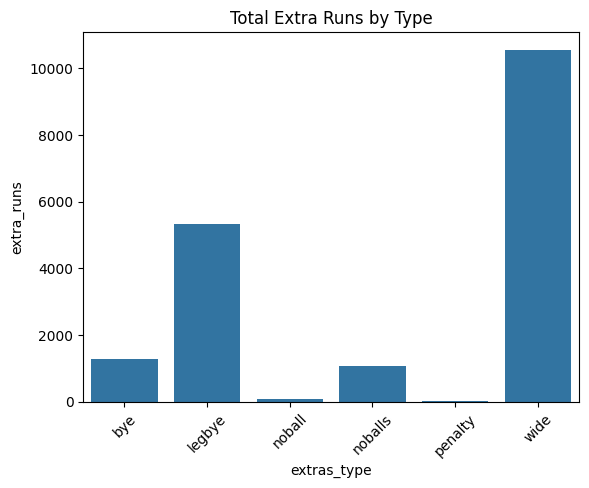

In [17]:
extra_stats = df.groupby('extras_type')['extra_runs'].sum().reset_index()
sns.barplot(data=extra_stats, x='extras_type', y='extra_runs')
plt.title("Total Extra Runs by Type")
plt.xticks(rotation=45)
plt.show()

Leg byes (5495) and wides (10,882) together account for the majority of extra runs, suggesting bowlers concede more runs through wayward deliveries than no-balls.

Next step: investigate whether specific bowlers or venues drive these extra runs, and assess impact on match outcomes.

**Setting consistent color palette for teams**

## **Overall Stats** :

In [18]:
# How all teams performed in different phases :
overall_stats = df.groupby('phase').agg(
    deliveries = ('ball', 'count'),
    total_runs=('total_runs', 'sum'),
    wickets=('player_dismissed', lambda x: x.notna().sum()),
    boundaries=('batsman_runs', lambda x: (x >= 4).sum()),
    fours = ('is_four','sum'),
    sixes = ('is_six','sum'),
    dot_balls = ('is_dot_ball','sum')
).round(2)

overall_stats['run_rate'] = (overall_stats['total_runs'] / (overall_stats['deliveries']/6)).round(2)
overall_stats['balls_per_wicket'] = (overall_stats.apply(lambda row: row['deliveries'] / row['wickets']
                                                           if row['wickets'] > 0 else np.nan,axis=1)).round(2)
overall_stats['dot_ball_percentage'] = (overall_stats['dot_balls'] /overall_stats['deliveries'] * 100).round(2)
overall_stats['boundary_percentage'] = (overall_stats['boundaries'] / overall_stats['deliveries'] * 100).round(2)
overall_stats['Six_Rate'] = (overall_stats['sixes'] / overall_stats['deliveries'] * 100).round(2)

print("📈 Overall Phase Statistics:")
display(overall_stats)

📈 Overall Phase Statistics:


,deliveries,total_runs,wickets,boundaries,fours,sixes,dot_balls,run_rate,balls_per_wicket,dot_ball_percentage,boundary_percentage,Six_Rate
phase,,,,,,,,,,,,
Death,48325,78550,4202,9851,5742,4105,16352,9.75,11.50,33.84,20.38,8.49
Middle,123417,161325,5494,17520,11303,6204,42901,7.84,22.46,34.76,14.20,5.03
Powerplay,98078,122850,3687,17719,14087,3585,47696,7.52,26.60,48.63,18.07,3.66


In [19]:
# Create subplot figure
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=('Run Rate by Phase','Balls per Wicket','Boundary Percentage',
                                    'Sixes Percentage','Dot Ball Percentage', 'Wickets per Phase'),
                    specs=[[{"secondary_y": False}, {"secondary_y": False}],
                           [{"secondary_y": False},{"secondary_y": False}],
                          [{"secondary_y": False}, {"secondary_y": False}]])

# Colors for phases
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Run Rate
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['run_rate'],
                     name='Run Rate',marker_color=colors,
                     text=overall_stats['run_rate'],textposition='outside',
                     hovertemplate='<b>%{x}</b><br>Run Rate: %{y:.2f}<extra></extra>'),
              row=1, col=1)

# Balls per Wicket
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['balls_per_wicket'],
                     name='Balls played per Wickets',marker_color=colors,
                     text=overall_stats['wickets'],textposition='outside',
                     hovertemplate='<b>%{x}</b><br>Wickets: %{y}<extra></extra>'),
              row=1, col=2)

# Boundary Percentage
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['boundary_percentage'],
                     name='Boundary %',marker_color=['#FF9999', '#66B2FF', '#99FF99'],
                     text=overall_stats['boundary_percentage'],textposition='outside',
                     hovertemplate='<b>%{x}</b><br>Boundary %: %{y:.1f}%<extra></extra>'),
              row=2, col=1)

# Sixes Percentage
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['Six_Rate'],
                     name='Sixes %',marker_color=['#FF9999', '#66B2FF', '#99FF99'],
                     text=overall_stats['boundary_percentage'],textposition='outside',
                     hovertemplate='<b>%{x}</b><br>Boundary %: %{y:.1f}%<extra></extra>'),
              row=2, col=2)

# Dot Ball Percentage
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['dot_ball_percentage'],
                     name='Dot Ball %',marker_color=['#FFB366', '#B366FF', '#66FFB3'],
                     text=overall_stats['dot_ball_percentage'],textposition='outside',
                    hovertemplate='<b>%{x}</b><br>Dot Ball %: %{y:.1f}%<extra></extra>'),
              row=3, col=1)

# Wickets
fig.add_trace(go.Bar(x=overall_stats.index,y=overall_stats['wickets'],
                     name='Total Wickets',marker_color=colors,
                     text=overall_stats['wickets'],textposition='outside',
                     hovertemplate='<b>%{x}</b><br>Wickets: %{y}<extra></extra>'),
              row=3, col=2)


# Update layout
fig.update_layout(title={'text': '📊 IPL Phase Analysis Dashboard','x': 0.5,
                         'xanchor': 'center',
                         'font': {'size': 20, 'color': '#2E86AB'}},
                  height=1500,showlegend=False,template='plotly_white',
                  font=dict(size=12))

# Update axes
fig.update_xaxes(title_font_size=14)
fig.update_yaxes(title_font_size=14)

fig.show()

- **Death overs** have the highest run rate (9.75) but also the most frequent wickets (11.5 balls per wicket).

- **Wicket Pattern**: Death overs show lowest balls per wicket, indicating high-risk batting

- **Middle overs** strike the best balance of moderate scoring rate (~7.85) and lower wicket risk.

- **Insight**: teams may optimize batting approach by protecting wickets early in the death overs.

## Season- wise phase  Analysis

In [20]:
season_stats = df.groupby(['season','phase']).agg(
    deliveries=('ball', 'count'),
    total_runs=('total_runs', 'sum'),
    wickets=('player_dismissed', lambda x: x.notna().sum()),
    boundaries=('batsman_runs', lambda x: (x >= 4).sum()),
    fours = ('is_four','sum'),
    sixes = ('is_six','sum'),
    dot_balls = ('is_dot_ball','sum')
).reset_index()

season_stats['run_rate'] = (season_stats['total_runs'] / (season_stats['deliveries']/6)).round(2)
season_stats['balls_per_wicket'] = season_stats.apply(lambda row: row['deliveries'] / row['wickets']
                                                        if row['wickets'] > 0 else np.nan,axis=1)
season_stats['dot_ball_percentage'] = (season_stats['dot_balls'] /season_stats['deliveries'] * 100).round(2)
season_stats['boundary_percentage'] = (season_stats['boundaries'] / season_stats['deliveries'] * 100).round(2)
season_stats['Six_Rate'] = (season_stats['sixes'] / season_stats['deliveries'] * 100).round(2)
print("📈 Season wise phase Statistics:")
display(season_stats.tail(3))

📈 Season wise phase Statistics:


,season,phase,deliveries,total_runs,wickets,boundaries,fours,sixes,dot_balls,run_rate,balls_per_wicket,dot_ball_percentage,boundary_percentage,Six_Rate
51,2025,Death,2851,4996,253,671,354,317,974,10.51,11.268775,34.16,23.54,11.12
52,2025,Middle,7707,11386,355,1383,839,543,2489,8.86,21.709859,32.30,17.94,7.05
53,2025,Powerplay,6112,9250,241,1400,996,403,2613,9.08,25.360996,42.75,22.91,6.59


In [21]:
def create_season_trends(df,metric,by):
  fig = px.line(
        df,
        x='season',
        y= metric,
        color= by,
        title=f'📈 Evolution of {metric} Across IPL Seasons',
        labels={ 'run_rate' : 'Run Rate (RPO)','wickets' : 'Total Wickets', 'season': 'IPL Season'},
        color_discrete_map={
            'Powerplay': '#FF6B6B',
            'Middle': '#4ECDC4',
            'Death': '#45B7D1'})
  # Enhanced styling
  hover_labels = {'run_rate': 'Run Rate','wickets': 'Wickets'}
  label = hover_labels.get(metric, metric.replace('_', ' ').title())
  fig.update_traces(mode='lines+markers',line=dict(width=4),marker=dict(size=8),
                    hovertemplate='<b>%{fullData.name}</b><br>' +
                    'Season: %{x}<br>' +
                    f'{label} : ' +'%{y:.2f} <extra></extra>')

  fig.update_layout(title_font_size=18,title_x=0.5,height=500,
                    hovermode='x unified',legend=dict(orientation="h",
                                                      yanchor="bottom",
                                                      y=1.02,xanchor="right",
                                                      x=1))

  return fig

In [22]:
def create_animated_trends(df):
    trends_df = pd.DataFrame(df)

    # Step 1: Get global x and y range
    x_min = trends_df['boundary_percentage'].min() * 0.95
    x_max = trends_df['boundary_percentage'].max() * 1.05
    y_min = trends_df['run_rate'].min() * 0.95
    y_max = trends_df['run_rate'].max() * 1.05

    # Create animated scatter with size
    fig = px.scatter(
        trends_df,
        x='boundary_percentage',
        y='run_rate',
        size='deliveries',
        color='phase',
        animation_frame='season',
        title='🎬 IPL Phase Dynamics Over Time',
        labels={
            'boundary_percentage': 'Boundary Rate (%)',
            'run_rate': 'Run Rate (RPO)',
            'deliveries': 'Total Deliveries'
        },
        size_max=60
    )

    fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

    fig.update_layout(
        title_font_size=18,
        title_x=0.5,
        height=600,
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max])
    )

    return fig

In [23]:
season_trends_fig = create_season_trends(season_stats,'run_rate','phase')
season_trends_fig.show()

### Season Trend Analysis:
- **Overall Trend**: Run rates increased over time across all phases
- **Death Overs Evolution**: Most significant improvement from ~9.89 (2008) to ~10.51 (2025)
- **Powerplay Stability**: Run rate increased from 7.22 in 2008 to 9.09 in 2025. Indicates more aggressive starts and effective powerplay utilization in recent seasons.
- **Strategic Shift**: Teams increasingly target powerplay and death overs for acceleration and focus on steady improvement in middel overs.

In [24]:
animated_fig = create_animated_trends(season_stats)
animated_fig.show()

In [25]:
season_trends_fig1 = create_season_trends(season_stats,'wickets','phase')
season_trends_fig1.show()

## Team wise Phase analysis

## Team Batting Analysis by phase

Using recent seasons from 2021–2025 to reflect the current game strategies in each phase.

In [26]:
recent_seasons = df[df['season'] >= 2020].copy()

In [27]:
team_batting_2025 = phase_agg(recent_seasons, role='team_batting', min_balls = 120)
team_batting_2025.head(3)

,cleaned_team_batting,phase,total_runs,balls,wickets,dot_balls,boundaries,fours,sixes,run_rate,balls_played_per_wkt,dot_ball_pct,boundary_pct,dismissal_rate,six_pct,team_performance_index
0,CSK,Death,3510,2011,141,656,454,244,210,10.47,14.26,0.33,0.23,0.07,10.44,1.513649
1,CSK,Middle,6417,4801,212,1594,695,425,270,8.02,22.65,0.33,0.14,0.04,5.62,-0.375021
2,CSK,Powerplay,4795,3727,129,1701,675,529,146,7.72,28.89,0.46,0.18,0.03,3.92,-1.552088


In [28]:
# Top 5 Batting teams by Phase
for phase in ['Powerplay', 'Middle', 'Death']:
    print(f"\n🏆 Top 5 Teams in {phase} (2020-2025):")
    top_teams = team_batting_2025[team_batting_2025['phase'] == phase]\
                .nlargest(5, 'team_performance_index')[['cleaned_team_batting','total_runs','run_rate', 'boundary_pct','six_pct','sixes']]
    display(top_teams)


🏆 Top 5 Teams in Powerplay (2020-2025):


,cleaned_team_batting,total_runs,run_rate,boundary_pct,six_pct,sixes
5,DC,5088,8.26,0.21,4.55,168
20,PBKS,4906,8.14,0.20,4.67,169
29,SRH,5112,8.23,0.20,4.93,184
26,RR,5202,8.26,0.22,5.26,199
8,GT,3414,7.95,0.19,3.14,81



🏆 Top 5 Teams in Middle (2020-2025):


,cleaned_team_batting,total_runs,run_rate,boundary_pct,six_pct,sixes
7,GT,4694,8.56,0.16,5.08,167
13,LSG,4617,8.65,0.17,7.02,225
16,MI,6671,8.36,0.17,6.16,295
22,RCB,6703,8.17,0.15,5.85,288
19,PBKS,6364,8.30,0.16,7.05,324



🏆 Top 5 Teams in Death (2020-2025):


,cleaned_team_batting,total_runs,run_rate,boundary_pct,six_pct,sixes
15,MI,3154,10.39,0.23,10.82,197
6,GT,2322,10.42,0.23,10.32,138
0,CSK,3510,10.47,0.23,10.44,210
21,RCB,3209,10.09,0.22,9.64,184
27,SRH,2990,9.61,0.20,8.31,155


In [29]:
# Create custom heatmap
def plot_heatmap(df,phase,metric):
  heatmap_data = df.pivot(index=phase,
                                     columns='phase', values=metric)
  fig = go.Figure(data=go.Heatmap(z=heatmap_data.values,
                                  x=heatmap_data.columns,
                                  y=heatmap_data.index,
                                  colorscale='RdYlGn',
                                  hoverongaps=False,
                                  hovertemplate='<b>%{y}</b><br>' +
                                  'Phase: %{x}<br>' +
                                  f'{metric.replace("_", " ").title()}: %{{z:.2f}}<extra></extra>',
                                  colorbar=dict(
                                      title=f"{metric.replace('_', ' ').title()}",
                                      titleside="right",
                                      tickmode="linear",
                                      tick0=heatmap_data.values.min(),
                                      dtick=(heatmap_data.values.max() - heatmap_data.values.min()) / 10
                                  )
    ))

  # Add text annotations
  annotations = []
  for i, team in enumerate(heatmap_data.index):
        for j, phase in enumerate(heatmap_data.columns):
            value = heatmap_data.iloc[i, j]
            if not pd.isna(value):
                annotations.append(dict(
                    x=phase,
                    y=team,
                    text=f'{value:.1f}',
                    font=dict(color='white' if value < heatmap_data.values.mean() else 'black'),
                    showarrow=False
                ))

  fig.update_layout(title={'text': f'🔥 Team {metric.replace("_", " ").title()} Heatmap by Phase',
                          'x': 0.5,'font': {'size': 18}},
                    annotations=annotations,height=500,width=800)
  return fig

run_rate_heatmap = plot_heatmap(team_batting_2025,'cleaned_team_batting', 'run_rate')
run_rate_heatmap.show()

In [30]:
team_batting = season_team_phase_groupby(df,'batting')

In [31]:
# PLotting line chart for top team :
teams = ['CSK','DC','MI','RCB','SRH']
for i  in teams:
  print(f"For {i} Team")
  plot_bat = create_season_trends(team_batting[team_batting['cleaned_team_batting']==i],'run_rate','phase')
  plot_bat.show()

For CSK Team


For DC Team


For MI Team


For RCB Team


For SRH Team


**Insights**

- **For Chennai Super Kings**:

1. **Strength Phase**: The Death phase consistently records the highest run rates, averaging 10.27 RPO across seasons.

2. **Trend**: Over the last five seasons, their Death-over run rate has decreased from 11.50 RPO in 2021 to 9.50 RPO in 2025, signaling a moderation of their once-dominant finishing attack.

3. **Volatility**: The Death-over run rate shows high year-over-year variability , with notable outliers in 2018 and 2021 when CSK recorded peaks above 11 RPO.

- **For Delhi Capitals**:

1. **Middle Overs Strength**
The Middle‐overs line consistently sits near or above the powerplay phases, averaging 7.72 RPO. DC’s ability to rotate strike and capitalize on loose bowling in overs 7–15 has been their hallmark.

2. **Death Overs Acceleration**
Death‐overs run‐rate climbs from about 9.0 RPO in 2020 to 10.5 RPO by 2024, reflecting the impact of specialist finishers (e.g., Sam Curran, Avesh Khan). Their Death‐over scoring surge peaked in 2024 before a slight dip in 2025.

3. **Volatility** :
Powerplay run‐rate was highly variable early on—dipping as low as 6.4 RPO in 2011—but has trended upward recently, hitting 10.0 RPO in 2024. This late Powerplay boost suggests the success of aggressive openers like David Warner and Prithvi Shaw in setting the tone.

- **For Mumbai Indians**:

1. **Death Overs Mastery**
The Death‐over run rate consistently leads, with peaks around 11.8 RPO in 2015 and 11.6 RPO in 2018, reflecting MI’s reliance on death‐over specialists like Jasprit Bumrah and Hardik Pandya.

2. **Middle Overs Stability**
Middle overs  climb steadily from 7.2 RPO in 2012 to 8.2 RPO by 2025, indicating MI’s strong spin‐seam combination controlling the middle phase throughout their title runs.

3. **Powerplay Evolution**
Powerplay scoring saw lows near 5.9 RPO in 2009, but after 2017, it rose to 9.0 RPO in 2024–25, underlining MI’s successful opening pair acquisitions like Quinton de Kock and Ishan Kishan.

- **For Royal Challengers Bangalore**:

1. **Death Overs Prowess** :
Death overs consistently top RCB’s phase run rates, averaging 10.82 RPO across seasons, with a peak of 12.12 RPO in 2016—reflecting their all-round firepower in the final overs.

2. **Powerplay Improvement** :
Over the last five seasons, RCB’s Powerplay run rate has increased from 6.94 RPO in 2020 to 9.32 RPO in 2025, signaling a successful shift toward aggressive opening duos like Maxwell–Padikkal and the acquisition of explosive marquee players.

3. **Middle Overs Consistency**:
Middle-overs run rate remains remarkably stable, hovering around 8.15 RPO, with only minor dips in 2017 and 2020. This steadiness highlights RCB’s ability to consolidate after the Powerplay before the death-over assault.

- **For Sunrisers Hyderabad**:

1. **Death Overs Edge**:
Death overs consistently lead with an average of 9.54 RPO, peaking at 10.40 RPO in 2008 and rising again to 10.50 RPO in 2024, highlighting SRH’s knack for finishing strongly under pressure.

2. **Middle Overs Focus**:
Over the last five seasons, SRH’s Middle‐overs run rate has increased from 6.80 RPO in 2021 to 9.00 RPO in 2025, signaling growth in their spin‐seam combination controlling the middle overs.

3. **Volatility** :
Powerplay run rates show high variability, dipping to 6.00 RPO in 2014 and jumping to 10.30 RPO in 2024, reflecting changes in opener strategies and key recruitments like Williamson–Bairstow.

## Team Bowling Analysis by Phase

In [32]:
team_bowling_2025 = phase_agg(recent_seasons, role='team_bowling', min_balls = 120)
team_bowling_2025.head(3)

,cleaned_team_bowling,phase,total_runs,balls,wickets,dot_balls,boundaries,fours,sixes,economy_rate,balls_bowled_per_wkt,dot_ball_pct,boundary_pct,dismissal_rate,six_pct,team_performance_index
0,CSK,Death,3051,1933,167,745,376,227,149,9.47,11.57,0.39,0.19,0.09,7.71,-1.267645
1,CSK,Middle,6257,4758,220,1635,654,384,270,7.89,21.63,0.34,0.14,0.05,5.67,1.233583
2,CSK,Powerplay,5040,3731,136,1652,736,560,176,8.11,27.43,0.44,0.20,0.04,4.72,0.841610


In [33]:
# Top 5 Bowling teams by Phase
for phase in ['Powerplay', 'Middle', 'Death']:
    print(f"\n🏆 Top 5 Teams in {phase} (2020-2025):")
    top_teams = team_bowling_2025[team_bowling_2025['phase'] == phase]\
                .nlargest(5, 'team_performance_index')[['cleaned_team_bowling','total_runs','economy_rate', 'boundary_pct','six_pct','sixes']]
    display(top_teams)


🏆 Top 5 Teams in Powerplay (2020-2025):


,cleaned_team_bowling,total_runs,economy_rate,boundary_pct,six_pct,sixes
26,RR,4896,7.75,0.18,3.93,149
20,PBKS,4868,8.08,0.20,4.17,151
17,MI,5014,7.81,0.19,4.41,170
5,DC,4859,7.88,0.19,4.49,166
11,KKR,4870,8.08,0.19,4.90,177



🏆 Top 5 Teams in Middle (2020-2025):


,cleaned_team_bowling,total_runs,economy_rate,boundary_pct,six_pct,sixes
1,CSK,6257,7.89,0.14,5.67,270
10,KKR,5917,7.78,0.14,5.68,259
25,RR,6837,8.42,0.15,5.95,290
28,SRH,6539,8.33,0.16,5.96,281
4,DC,6417,8.11,0.15,5.84,277



🏆 Top 5 Teams in Death (2020-2025):


,cleaned_team_bowling,total_runs,economy_rate,boundary_pct,six_pct,sixes
0,CSK,3051,9.47,0.19,7.71,149
21,RCB,3043,9.68,0.20,9.38,177
15,MI,2976,9.70,0.21,9.23,170
6,GT,2110,9.93,0.21,10.59,135
27,SRH,3034,10.14,0.22,8.35,150


In [34]:
team_bowling_heatmap = plot_heatmap(team_bowling_2025,'cleaned_team_bowling', 'economy_rate')
team_bowling_heatmap.show()

In [35]:
team_bowling = season_team_phase_groupby(df,'bowling')
team_bowling[team_bowling['cleaned_team_bowling']=='CSK'].tail(3)

,season,cleaned_team_bowling,phase,deliveries,total_runs,wickets,boundaries,fours,sixes,dot_balls,economy_rate,balls_bowled_per_wkt,dot_ball_percentage,boundary_percentage,Six_Rate
438,2025,CSK,Death,275,462,25,60,28,32,114,10.08,11.00,41.45,21.82,11.64
439,2025,CSK,Middle,755,1091,36,125,71,54,254,8.67,20.97,33.64,16.56,7.15
440,2025,CSK,Powerplay,604,907,22,141,93,48,265,9.01,27.45,43.87,23.34,7.95


In [36]:
for i  in team_bowling['cleaned_team_bowling'].unique():
  print(f"For {i} Team")
  plot_bowl = create_season_trends(team_bowling[team_bowling['cleaned_team_bowling']==i],'wickets','phase')
  plot_bowl.show()

For CSK Team


For DC Team


For KKR Team


For MI Team


For PBKS Team


For RCB Team


For RR Team


For SRH Team


For Kochi Tuskers Kerala Team


For Pune Warriors Team


For GT Team


For Rising Pune Supergiants Team


For LSG Team


## Batting Analysis by Phase

In [37]:
min_balls_config = {
    'Powerplay': 200,
    'Middle': 200,
    'Death': 50
}

player_batting = phase_agg(df=recent_seasons, role='batting', min_balls=min_balls_config)

In [38]:
player_batting.head(3)

,striker,phase,runs,balls_faced,lost_wicket,dot_balls,boundaries,fours,sixes,strike_rate,balls_per_dismissal,batting_avg,dot_ball_pct,boundary_pct,six_pct,dismissal_rate,performance_index
14,AB de Villiers,Death,323,151,9,36,47,22,25,213.91,16.78,35.89,0.24,0.31,16.56,0.06,1.536213
15,AB de Villiers,Middle,333,272,11,87,33,24,9,122.43,24.73,30.27,0.32,0.12,3.31,0.04,-1.055961
20,AJ Finch,Powerplay,237,234,12,124,33,26,7,101.28,19.50,19.75,0.53,0.14,2.99,0.05,-1.332472


In [39]:
player_batting[player_batting['striker']=='Kohli']

,striker,phase,runs,balls_faced,lost_wicket,dot_balls,boundaries,fours,sixes,strike_rate,balls_per_dismissal,batting_avg,dot_ball_pct,boundary_pct,six_pct,dismissal_rate,performance_index
353,Kohli,Death,258,151,11,31,28,15,13,170.86,13.73,23.45,0.21,0.19,8.61,0.07,-0.139597
354,Kohli,Middle,1354,1082,32,301,129,85,44,125.14,33.81,42.31,0.28,0.12,4.07,0.03,0.012658
355,Kohli,Powerplay,1634,1245,35,482,235,191,44,131.24,35.57,46.69,0.39,0.19,3.53,0.03,0.811968


In [40]:
player_batting[player_batting['striker']=='YBK Jaiswal']

,striker,phase,runs,balls_faced,lost_wicket,dot_balls,boundaries,fours,sixes,strike_rate,balls_per_dismissal,batting_avg,dot_ball_pct,boundary_pct,six_pct,dismissal_rate,performance_index
844,YBK Jaiswal,Middle,589,417,23,119,71,45,26,141.25,18.13,25.61,0.29,0.17,6.24,0.06,-0.221078
845,YBK Jaiswal,Powerplay,1476,973,36,448,264,205,59,151.70,27.03,41.00,0.46,0.27,6.06,0.04,1.695100


In [41]:
# 6.2 Top Performers by Phase
for phase in ['Powerplay', 'Middle', 'Death']:
    print(f"\n⭐ Top 5 Batsmen in {phase} (min 200 balls, 2020-2025):")
    top_batsmen = player_batting[player_batting['phase'] == phase]\
                  .nlargest(5, 'performance_index')[['striker', 'strike_rate', 'runs','balls_faced','boundaries','boundary_pct','sixes','six_pct']]
    display(top_batsmen)


⭐ Top 5 Batsmen in Powerplay (min 200 balls, 2020-2025):


,striker,strike_rate,runs,balls_faced,boundaries,boundary_pct,sixes,six_pct
783,TM Head,206.79,457,221,82,0.37,26,11.76
845,YBK Jaiswal,151.70,1476,973,264,0.27,59,6.06
576,RR Pant,110.95,223,201,31,0.15,7,3.48
46,Abhishek Sharma,156.63,1145,731,187,0.26,60,8.21
199,F du Plessis,135.10,1632,1208,248,0.21,59,4.88



⭐ Top 5 Batsmen in Middle (min 200 balls, 2020-2025):


,striker,strike_rate,runs,balls_faced,boundaries,boundary_pct,sixes,six_pct
549,Pooran,160.34,1233,769,168,0.22,92,11.96
763,Suryakumar Yadav,157.07,1800,1146,257,0.22,80,6.98
692,Samson,147.80,1376,931,169,0.18,82,8.81
351,Klaasen,155.29,896,577,105,0.18,54,9.36
123,Buttler,151.48,1177,777,151,0.19,53,6.82



⭐ Top 5 Batsmen in Death (min 200 balls, 2020-2025):


,striker,strike_rate,runs,balls_faced,boundaries,boundary_pct,sixes,six_pct
756,Stubbs,245.59,334,136,50,0.37,22,16.18
733,Shreyas Iyer,246.30,133,54,23,0.43,12,22.22
725,Shepherd,235.29,160,68,27,0.40,15,22.06
762,Suryakumar Yadav,218.99,346,158,59,0.37,25,15.82
14,AB de Villiers,213.91,323,151,47,0.31,25,16.56


In [42]:
def create_player_radar(df, player_name, min_balls=100):
    """Create radar chart for individual player analysis"""

    # Filter player data
    player_data = df[df['striker'] == player_name]

    if len(player_data) < min_balls:
        print(f"Insufficient data for {player_name}")
        return None

    # Calculate phase-wise metrics
    phase_metrics = player_data.groupby('phase').agg({
        'batsman_runs': 'sum',
        'ball': 'count',
        'is_boundary': 'sum',
        'is_six': 'sum',
        'is_dot_ball': 'sum'
    }).reset_index()

    phase_metrics['strike_rate'] = (phase_metrics['batsman_runs'] /
                                   phase_metrics['ball'] * 100).round(2)
    phase_metrics['boundary_rate'] = (phase_metrics['is_boundary'] /
                                     phase_metrics['ball'] * 100).round(2)
    phase_metrics['six_rate'] = (phase_metrics['is_six'] /
                                phase_metrics['ball'] * 100).round(2)
    phase_metrics['dot_avoidance'] = (100 - phase_metrics['is_dot_ball'] /
                                     phase_metrics['ball'] * 100).round(2)

    # Prepare radar chart data
    categories = ['Strike Rate', 'Boundary Rate', 'Six Rate', 'Dot Avoidance']

    fig = go.Figure()

    # Add trace for each phase
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for i, phase in enumerate(['Powerplay', 'Middle', 'Death']):
        if phase in phase_metrics['phase'].values:
            phase_data = phase_metrics[phase_metrics['phase'] == phase].iloc[0]
            values = [
                phase_data['strike_rate'],
                phase_data['boundary_rate'],
                phase_data['six_rate'],
                phase_data['dot_avoidance']
            ]

            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=categories,
                fill='toself',
                name=phase,
                line=dict(color=colors[i], width=3),
                marker=dict(size=8, color=colors[i])
            ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max(phase_metrics[['strike_rate', 'boundary_rate',
                                           'six_rate', 'dot_avoidance']].max()) * 1.1]
            ),
            angularaxis=dict(
                tickfont=dict(size=12)
            )
        ),
        showlegend=True,
        title={
            'text': f'⭐ {player_name} - Phase Performance Radar',
            'x': 0.5,
            'font': {'size': 18}
        },
        height=600,
        width=600
    )

    return fig

In [43]:
player_radar = create_player_radar(recent_seasons, 'MS Dhoni')
player_radar.show()

In [44]:
player_radar = create_player_radar(recent_seasons, 'Kohli')
player_radar.show()

In [45]:
player_radar = create_player_radar(recent_seasons, 'Rohit Sharma')
player_radar.show()

## Bowling Analysis by Phase

In [46]:
player_bowling = phase_agg(recent_seasons, role='bowling', min_balls = 120)
player_bowling.sort_values('performance_index', ascending=False).head(5)

,bowler,phase,runs_conceded,balls_bowled,wickets,dot_balls,boundaries,fours,sixes,economy_rate,balls_per_wicket,bowling_avg,dot_ball_pct,boundary_pct,six_pct,performance_index
259,JC Archer,Powerplay,194,219,10,138,25,17,8,5.32,21.90,19.40,0.63,0.11,0.04,2.823695
686,TA Boult,Powerplay,1144,1032,53,595,186,163,23,6.65,19.47,21.58,0.58,0.18,0.02,2.248274
419,Mohammed Shami,Powerplay,979,858,36,499,148,124,24,6.85,23.83,27.19,0.58,0.17,0.03,2.062783
106,Bumrah,Powerplay,650,589,24,337,94,73,21,6.62,24.54,27.08,0.57,0.16,0.04,1.961116
160,DJ Willey,Powerplay,122,121,3,55,14,12,2,6.05,40.33,40.67,0.45,0.12,0.02,1.925724


In [47]:
for phase in ['Powerplay', 'Middle', 'Death']:
    print(f"\n🎳 Top 5 Economical Bowlers in {phase} (min {120//6} overs, 2020-2024):")
    top_bowlers = player_bowling[player_bowling['phase'] == phase]\
                  .nlargest(5, 'performance_index')[['bowler','economy_rate', 'wickets','runs_conceded','dot_balls','balls_per_wicket','bowling_avg']]
    display(top_bowlers)


🎳 Top 5 Economical Bowlers in Powerplay (min 20 overs, 2020-2024):


,bowler,economy_rate,wickets,runs_conceded,dot_balls,balls_per_wicket,bowling_avg
259,JC Archer,5.32,10,194,138,21.90,19.40
686,TA Boult,6.65,53,1144,595,19.47,21.58
419,Mohammed Shami,6.85,36,979,499,23.83,27.19
106,Bumrah,6.62,24,650,337,24.54,27.08
160,DJ Willey,6.05,3,122,55,40.33,40.67



🎳 Top 5 Economical Bowlers in Middle (min 20 overs, 2020-2024):


,bowler,economy_rate,wickets,runs_conceded,dot_balls,balls_per_wicket,bowling_avg
531,Prasidh,6.47,10,164,69,15.20,16.40
362,M Pathirana,6.70,12,279,121,20.83,23.25
258,JC Archer,6.81,6,143,63,21.00,23.83
105,Bumrah,6.37,35,529,221,14.23,15.11
151,DJ Bravo,7.39,9,367,112,33.11,40.78



🎳 Top 5 Economical Bowlers in Death (min 20 overs, 2020-2024):


,bowler,economy_rate,wickets,runs_conceded,dot_balls,balls_per_wicket,bowling_avg
361,M Pathirana,7.90,18,270,92,11.39,15.00
104,Bumrah,7.37,39,646,202,13.49,16.56
150,DJ Bravo,8.39,25,316,85,9.04,12.64
114,CH Morris,8.91,16,196,58,8.25,12.25
420,Mohammed Siraj,8.94,22,551,164,16.82,25.05


## Plotting Charts

In [48]:
fig = px.bar(team_batting_2025, x='cleaned_team_batting', y='run_rate', color='phase',
             barmode='group', title='2025 Batting Run Rate by Team and Phase')
fig.update_layout(xaxis_title='Team', yaxis_title='Run Rate (Runs/Over)')
fig.show()

Rajasthan Royals led Powerplay scoring in 2025 (9.88 rpo), whereas Gujarat Titans dominated middle overs (9.55 rpo).

Punjab Kings excelled at death overs economy relative to peers—suggesting strong death-over batting.

Recommendation: weaker teams should analyze RR’s Powerplay approach and Punjabs’s death-over plans for best practices.

In [49]:
fig = px.bar(team_bowling_2025, x='cleaned_team_bowling', y='balls_bowled_per_wkt', color='phase',
             barmode='group', title='2025 Balls per wickets by Team and Phase')
fig.update_layout(xaxis_title='Team', yaxis_title='Economy Rate')
fig.show()

Powerplay: “Lucknow Super Gaints loses wickets more frequently in the Powerplay than other teams, suggesting a risky opening strategy.”

Middle Overs: “Rajasthan Royal have a high balls-per-dismissal ratio in the middle overs shows the team consolidates well, protecting wickets.”

Death Overs: “Gujrat Titans has the low balls-per-wicket during death overs indicates weak death batting and frequent breakthroughs under pressure.”

#### Comparative Visualization (2025 vs. Seasons till 2024)

In [50]:
overall_stats_24 = df[df['season'] < 2025].groupby('phase').agg(
    deliveries=('ball', 'count'),
    total_runs=('total_runs', 'sum'),
    wickets=('player_dismissed', lambda x: x.notna().sum()),
    boundaries=('batsman_runs', lambda x: (x >= 4).sum())
).reset_index()

overall_stats_24['run_rate'] = overall_stats_24['total_runs'] / (overall_stats_24['deliveries']/6)
overall_stats_24['strike_rate_wickets'] = overall_stats_24.apply(lambda row: row['deliveries'] / row['wickets']
                                                           if row['wickets'] > 0 else np.nan,axis=1)

overall_stats_24

,phase,deliveries,total_runs,wickets,boundaries,run_rate,strike_rate_wickets
0,Death,45474,73554,3949,9180,9.704974,11.515320
1,Middle,115710,149939,5139,16137,7.774903,22.516054
2,Powerplay,91966,113600,3446,16319,7.411435,26.687754


In [51]:
stats_2025 = df[df['season'] == 2025].groupby('phase').agg(
    deliveries=('ball', 'count'),
    total_runs=('total_runs', 'sum'),
    wickets=('player_dismissed', lambda x: x.notna().sum()),
    boundaries=('batsman_runs', lambda x: (x >= 4).sum())
).reset_index()

stats_2025['run_rate'] = stats_2025['total_runs'] / (stats_2025['deliveries']/6)
stats_2025['strike_rate_wickets'] = stats_2025.apply(lambda row: row['deliveries'] / row['wickets']
                                                           if row['wickets'] > 0 else np.nan,axis=1)

stats_2025

,phase,deliveries,total_runs,wickets,boundaries,run_rate,strike_rate_wickets
0,Death,2851,4996,253,671,10.514206,11.268775
1,Middle,7707,11386,355,1383,8.864149,21.709859
2,Powerplay,6112,9250,241,1400,9.080497,25.360996


In [52]:
df_compare = stats_2025.set_index('phase')[['run_rate']].rename(columns={'run_rate': '2025'})
df_compare['historical'] = overall_stats_24.set_index('phase')['run_rate']

df_compare = df_compare.reset_index().melt(id_vars='phase', var_name='Season', value_name='Run Rate')

df_compare = df_compare.sort_values(['phase', 'Season'])

fig = px.bar(df_compare, x='phase', y='Run Rate', color='Season', barmode='group',
             title='Run Rate: 2025 vs. Seasons(2008-24) by Phase')

fig.update_layout(
    bargap=0.1,
    bargroupgap=0.05
)

fig.show()

In 2025, Powerplay run rate jumped to 9.1 vs. historical 7.5, indicating more aggressive starts this season.

Death‐over run rates rose marginally compared to long‐term average, possibly reflecting improved slog-bowling strategies.

Question: is this shift driven by rule changes (e.g., fielding restrictions) or evolving batting techniques?

# Hypothesis Testing

**Null hypothesis (H₀)**: Change in Historical and recent period economy rate is random.

**Alternate hypothesis (H₁)**: Change in Historical and recent period economy rate is not random.

In [53]:
batting_stats_compare = season_team_phase_groupby(df,'batting')
batting_stats_compare.head(3)

,season,cleaned_team_batting,phase,deliveries,total_runs,wickets,boundaries,fours,sixes,dot_balls,run_rate,balls_played_per_wkt,dot_ball_percentage,boundary_percentage,Six_Rate
0,2008,CSK,Death,323,548,24,73,46,27,100,10.18,13.46,30.96,22.60,8.36
1,2008,CSK,Middle,829,1116,30,128,81,47,305,8.08,27.63,36.79,15.44,5.67
2,2008,CSK,Powerplay,671,801,25,121,109,12,365,7.16,26.84,54.40,18.03,1.79


In [54]:
bowling_stats_compare = season_team_phase_groupby(df,'bowling')
bowling_stats_compare.head(3)

,season,cleaned_team_bowling,phase,deliveries,total_runs,wickets,boundaries,fours,sixes,dot_balls,economy_rate,balls_bowled_per_wkt,dot_ball_percentage,boundary_percentage,Six_Rate
0,2008,CSK,Death,302,487,33,62,42,20,90,9.68,9.15,29.80,20.53,6.62
1,2008,CSK,Middle,822,1083,32,123,85,37,304,7.91,25.69,36.98,14.96,4.50
2,2008,CSK,Powerplay,660,849,23,119,91,28,326,7.72,28.70,49.39,18.03,4.24


In [55]:
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import ttest_ind, shapiro, levene


In [56]:
def calculate_cohens_d(data1, data2):
    """
    Compute Cohen's d to measure effect size between two samples.

    Args:
        data1 (array-like): Sample 1
        data2 (array-like): Sample 2

    Returns:
        float: Cohen's d value
    """
    n1, n2 = len(data1), len(data2)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    std1, std2 = np.std(data1, ddof=1), np.std(data2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 -1)*std1**2 + (n2 -1)*std2**2) / (n1 + n2 -2))

    if pooled_std == 0:
        return 0.0

    d = (mean1 - mean2) / pooled_std
    return d

In [57]:
def comprehensive_cricket_analysis(df, metric='economy_rate'):
    """
    Best practice: Combined approach for cricket season analysis
    """

    # PRIMARY ANALYSIS: Pooled periods (high power)
    historical_data = df[df['season'].between(2008, 2024)][metric]
    current_data = df[df['season'] == 2025][metric]

    # High-power test
    t_stat_pooled, p_val_pooled = stats.ttest_ind(historical_data, current_data)
    cohens_d_pooled = calculate_cohens_d(historical_data, current_data)

    # VALIDATION: Recent trend (2024 vs 2025)
    recent_2024 = df[df['season'] == 2024][metric]
    recent_2025 = df[df['season'] == 2025][metric]

    t_stat_recent, p_val_recent = stats.ttest_ind(recent_2024, recent_2025)

    # DECISION LOGIC
    if p_val_pooled < 0.05 and abs(cohens_d_pooled) > 0.2:
        return f"✅ Strong evidence: {metric} significantly changed (d={cohens_d_pooled:.3f})"
    elif p_val_pooled < 0.05:
        return f"⚠️ Weak evidence: Statistically significant but small effect (d={cohens_d_pooled:.3f})"
    else:
        return f"❌ No evidence: {metric} has not significantly changed"


In [58]:
# Usage:
bowling_result = comprehensive_cricket_analysis(bowling_stats_compare, 'economy_rate')
bowling_result

'✅ Strong evidence: economy_rate significantly changed (d=-0.948)'

In [59]:
batting_result = comprehensive_cricket_analysis(batting_stats_compare, 'run_rate')
batting_result

'✅ Strong evidence: run_rate significantly changed (d=-0.936)'

In [60]:
# Group by season and describe economy_rate (or any metric)
summary_stats = bowling_stats_compare.groupby('season')['economy_rate'].describe()

print(summary_stats)


        count      mean       std   min     25%    50%      75%    max
season                                                                
2008     24.0  8.330833  1.221246  6.77  7.4175  7.980   9.5225  10.99
2009     24.0  7.475417  1.272522  5.47  6.6975  7.055   8.2625  10.13
2010     24.0  8.173750  1.179163  6.80  7.3175  7.800   9.0300  11.06
2011     30.0  7.727333  1.024654  6.07  6.9325  7.560   8.5750   9.65
2012     27.0  7.908889  1.252694  6.19  7.0750  7.510   8.6550  10.77
2013     27.0  7.853333  1.424829  6.21  6.7550  7.250   8.8700  11.02
2014     24.0  8.310833  1.323460  6.79  7.2525  7.925   9.5425  11.13
2015     24.0  8.328333  1.284326  6.71  7.3900  7.800   9.1900  10.78
2016     24.0  8.375417  1.222289  6.55  7.6000  8.015   9.0525  11.03
2017     24.0  8.448750  0.968461  7.02  7.8050  8.115   9.0600  10.82
2018     24.0  8.607500  1.148527  7.35  7.7575  8.055   9.0450  11.28
2019     24.0  8.495833  1.340775  6.63  7.5550  8.055   8.9275  11.47
2020  

In [61]:
historical = bowling_stats_compare[bowling_stats_compare['season'] < 2025]
recent = bowling_stats_compare[bowling_stats_compare['season'] == 2025]

print("Historical Period Summary:")
print(historical['economy_rate'].describe())

print("\nRecent Period Summary:")
print(recent['economy_rate'].describe())


Historical Period Summary:
count    438.000000
mean       8.312922
std        1.260936
min        5.470000
25%        7.372500
50%        7.985000
75%        9.187500
max       12.340000
Name: economy_rate, dtype: float64

Recent Period Summary:
count    30.000000
mean      9.490000
std       0.900754
min       8.060000
25%       8.845000
50%       9.260000
75%      10.287500
max      11.380000
Name: economy_rate, dtype: float64


The mean economy rate is noticeably higher in the recent period (9.49) than historically (8.31), indicating that, on average, bowlers have conceded more runs per over in the recent seasons.

The spread (standard deviation) is narrower in the recent period (0.90) compared to historical (1.26), meaning recent economy rates are more tightly clustered around the mean.

Minimum and maximum values: The best (lowest) and worst (highest) economy rates both shifted higher in the recent period, which further supports the observation that scoring rates have gone up.


In [62]:
historical = batting_stats_compare[batting_stats_compare['season'] < 2025]
recent = batting_stats_compare[batting_stats_compare['season'] == 2025]

print("Historical Period Summary:")
print(historical['run_rate'].describe())

print("\nRecent Period Summary:")
print(recent['run_rate'].describe())

Historical Period Summary:
count    438.000000
mean       8.291210
std        1.300773
min        5.230000
25%        7.352500
50%        7.995000
75%        9.190000
max       12.140000
Name: run_rate, dtype: float64

Recent Period Summary:
count    30.000000
mean      9.491333
std       0.963026
min       7.780000
25%       8.935000
50%       9.280000
75%       9.972500
max      12.000000
Name: run_rate, dtype: float64


# Saving datasets

In [63]:
df.to_csv("ipl_phase_dataset.csv",index= False)
overall_stats.to_csv("overall_phase_stats.csv",index= False)
season_stats.to_csv("season_phase_stats.csv",index= False)

In [64]:
#Recent Phase analysis dataset
team_batting_2025.to_csv("team_batting_20_25.csv",index= False)
team_batting.to_csv("season_team_batting_phase.csv",index= False)
team_bowling_2025.to_csv("team_bowling_20_25.csv",index= False)
team_bowling.to_csv("season_team_bowling_phase.csv",index= False)
player_batting.to_csv("player_batting_20_25.csv",index= False)
player_bowling.to_csv("player_bowling_20_25.csv",index= False)

# **Key Takeaways:**  
- Death overs have the highest run rate (~9.8) but also highest wicket rate.  
- Powerplay features most boundaries per ball.  
- 2025 saw a significant uptick in Death overs run rate compared to historical average.

- **For CSK** :
CSK’s legendary death‐over finishing and middle‐overs control remain elite—boosting Powerplay aggression with a solid opener could elevate their match-winning totals.

- **For DC** :
DC's strong middle‐overs foundation and improving death‐over finishing need consistent Powerplay acceleration—maintaining their 2024 explosive starts could unlock championship‐level totals.

- **For MI** :
MI’s deadly death overs and steady middle‐overs can be amplified by a more explosive Powerplay—adding a hitter at the top could lift their totals

- **For SRH** :
SRH’s recent middle‐overs improvements paired with strong death‐over performance suggest a balanced batting order, but stabilizing the Powerplay with consistent explosive starts would make them even more competitive.

- **For RCB** :
While RCB’s finishing has been world-class, ensuring further Powerplay stability and targeting a slight middle-overs acceleration could push them from high-scoring contenders to consistent title challengers.

**🎯 Recommendations:**  

---
- **Strengthen Powerplay Impact**

1. Recruit or promote an aggressive opener to consistently deliver 8+ runs per over in the first six overs.

2. Target players with high Powerplay strike rates (e.g., T20 specialists).
---
- **Maintain Middle-Overs Control**

1. Continue leveraging spin-seam combinations to restrict run flow in overs 7–15.

2. Develop backup spinners/holders to sustain consistency when leading bowlers are unavailable.
---
- **Optimize Death-Over Strategy**

1. Retain your core death-over bowlers and rotate them for freshness late in seasons.

2. Use data-driven matchups to deploy finishers and bowlers against specific batting strengths.
---
- **Leverage Data for Team Selection**

Integrate phase-wise metrics and player indices into auction and retention decisions.

Use predictive models (e.g., Win Probability Added) to simulate lineup scenarios.
---
-** Continuous Monitoring and Adaptation**

1. Implement real-time dashboards for match-phase performance tracking.

2. Regularly review post-match phase analytics to refine tactics and personnel choices.
